### configure kaggle api to download dataset

In [1]:
from kaggle_secrets import UserSecretsClient
import os
username = "KAGGLE_USERNAME"
secret_label = "KAGGLE_API_KEY"
secret_value = UserSecretsClient().get_secret(secret_label) 

os.environ["KAGGLE_KEY"] = secret_value
os.environ[username] = "miguelaavila01"

### import libraries necessary for our notebook

In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')


## Bonus: Automatically download dataset from source

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

dataset = "mujtabamatin/air-quality-and-pollution-assessment"
out_dir = f"{os.getcwd()}/data"

api = KaggleApi()
api.authenticate()
api.dataset_download_files(dataset, path=out_dir, unzip=True)



Dataset URL: https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment


##### Exploring dataset

In [4]:
df = pd.read_csv(f'{out_dir}/updated_pollution_dataset.csv')  
df


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good


##### checking for null/missing values

In [5]:
print(df.shape)

(5000, 10)


In [6]:
print(df.isnull().sum())

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


#### Fixing column name by renaming the column to use snakke case to match the same format for the other fields

In [7]:
# Rename a single column
df.rename(columns={'Air Quality': 'Air_Quality'}, inplace=True)

In [1]:
order = df['Air_Quality'].value_counts().sort_values(ascending=False).index
sns.countplot(data=order, x='Air_Quality')
plt.show()


NameError: name 'df' is not defined

## encoding our column that we want to predict for our model

In [9]:
le = LabelEncoder()
df['Air_Quality_Label'] = le.fit_transform(df['Air_Quality'])


In [10]:
df

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air_Quality,Air_Quality_Label
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate,2
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate,2
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate,2
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,40.6,74.1,116.0,126.7,45.5,25.7,2.11,2.8,765,Hazardous,1
4996,28.1,96.9,6.9,25.0,25.3,10.8,1.54,5.7,709,Moderate,2
4997,25.9,78.2,14.2,22.1,34.8,7.8,1.63,9.6,379,Moderate,2
4998,25.3,44.4,21.4,29.0,23.7,5.7,0.89,11.6,241,Good,0


In [11]:
numeric_cols = ['Temperature', 'Humidity', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


### Checking correlation to see if there are fields that are correlated 

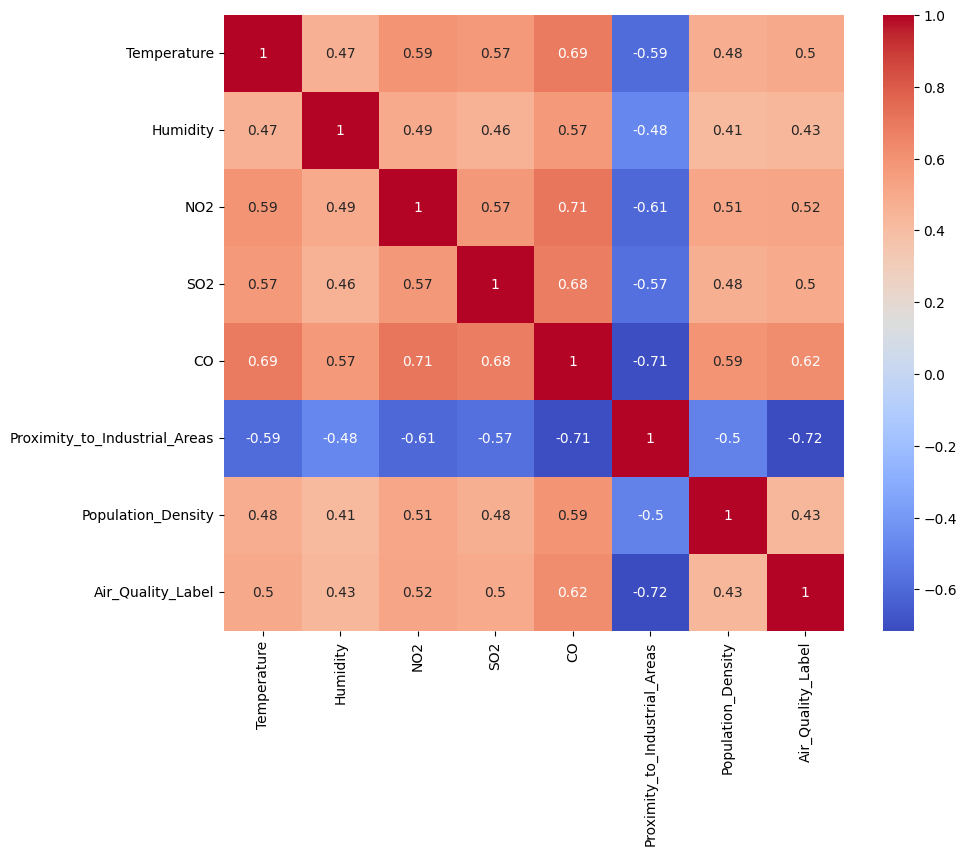

In [12]:
corr_matrix = df[numeric_cols + ['Air_Quality_Label']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


### as observed all fields are correlated making this a good dataset. However, we will use fields with abs value > .4

---

# Model training

## Preparing our dataset for training: training and testing dataset -> 70% for testing, 30% for validation 

In [13]:
X = df[numeric_cols]
y = df['Air_Quality_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


n_estimators=0 skipped (invalid)
n_estimators=2: Accuracy = 0.9107
n_estimators=3: Accuracy = 0.9300
n_estimators=5: Accuracy = 0.9400
n_estimators=10: Accuracy = 0.9440
n_estimators=50: Accuracy = 0.9527
n_estimators=100: Accuracy = 0.9533
n_estimators=150: Accuracy = 0.9507
n_estimators=250: Accuracy = 0.9507
n_estimators=500: Accuracy = 0.9507
n_estimators=1000: Accuracy = 0.9493

 BEST n_estimators = 100
 BEST Accuracy     = 0.9533



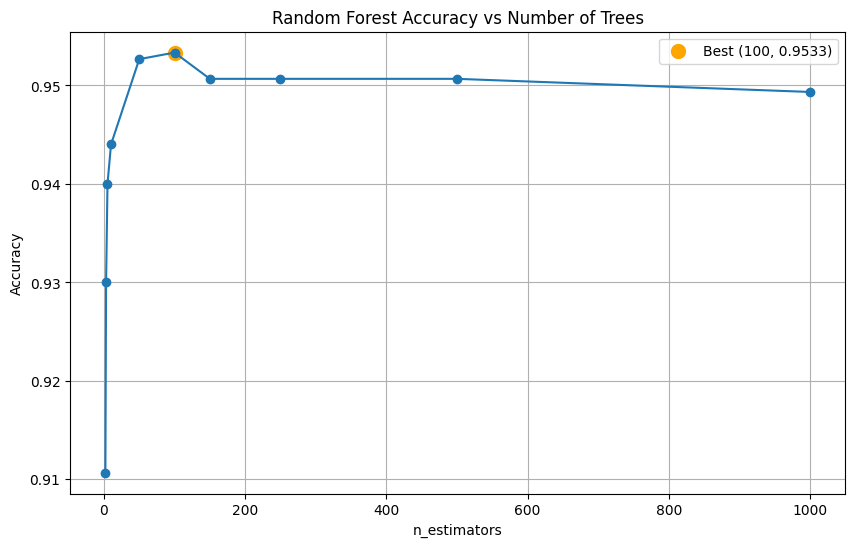

In [14]:
# List of n_estimators to test
estimators = [0, 2, 3, 5, 10, 50, 100, 150, 250, 500, 1000]

accuracies = []

for n in estimators:
    if n == 0:
        accuracies.append(None)
        print("n_estimators=0 skipped (invalid)")
        continue

    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"n_estimators={n}: Accuracy = {acc:.4f}")

# -----------------------------
# Find best value
# -----------------------------
# Filter out None values
valid_results = [(n, acc) for n, acc in zip(estimators, accuracies) if acc is not None]

# Pick the result with highest accuracy
best_n, best_acc = max(valid_results, key=lambda x: x[1])

print("\n==============================")
print(f" BEST n_estimators = {best_n}")
print(f" BEST Accuracy     = {best_acc:.4f}")
print("==============================\n")

# Plot accuracy vs n_estimators
plt.figure(figsize=(10, 6))
plt.plot(estimators, accuracies, marker='o')
plt.title("Random Forest Accuracy vs Number of Trees")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid(True)

# Highlight the best point in orange
plt.scatter(best_n, best_acc, color='orange', s=100, label=f"Best ({best_n}, {best_acc:.4f})")
plt.legend()

plt.show()

### using n values from 0 - 1000, we can see that the most optimate value is 100

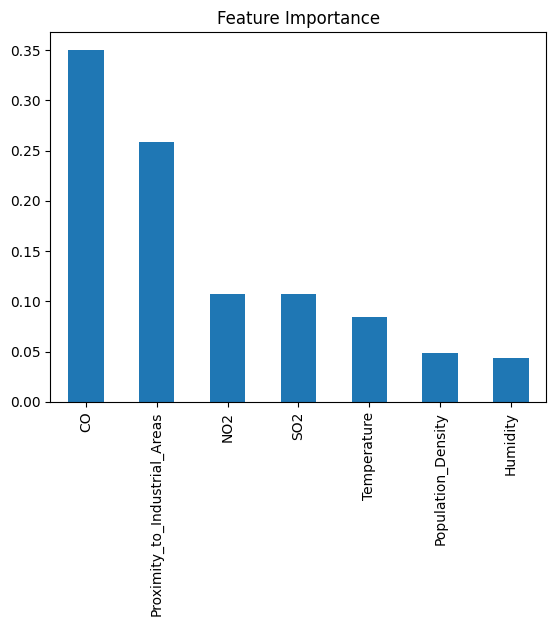

In [15]:
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=numeric_cols)
feat_importance.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importance")
plt.show()


In [16]:
# Feature selection based on correlation

corr_with_target = df[numeric_cols + ['Air_Quality_Label']].corr()['Air_Quality_Label'].abs().sort_values(ascending=False)
print("Correlation with target:\n", corr_with_target)

selected_features = corr_with_target[corr_with_target > 0.3].index.drop('Air_Quality_Label').tolist()
print("\nSelected Features:", selected_features)

X = df[selected_features]
y = df['Air_Quality_Label']

# Standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# HYPERPARAMETER SEARCH FOR ALL MODELS

import matplotlib.pyplot as plt
import seaborn as sns

results = []

# Decision Tree (test different depths)

dt_depths = [1, 2, 3, 5, 7, 10, 15, 20, 30, 50]
dt_accuracies = []

for d in dt_depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    dt_accuracies.append(acc)
    print(f"DecisionTree max_depth={d}: Acc={acc:.4f}")

best_dt_depth, best_dt_acc = max(zip(dt_depths, dt_accuracies), key=lambda x: x[1])
best_dt_model = DecisionTreeClassifier(max_depth=best_dt_depth, random_state=42).fit(X_train, y_train)


# Random Forest 

rf_estimators = [0, 5, 10, 50, 100, 150, 250, 500, 600, 750, 1000]
rf_accuracies = []

for n in rf_estimators:
    if n == 0:
        rf_accuracies.append(None)
        print("RF n_estimators=0 skipped")
        continue
    
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    rf_accuracies.append(acc)
    print(f"RandomForest n_estimators={n}: Acc={acc:.4f}")

valid_rf = [(n, a) for n, a in zip(rf_estimators, rf_accuracies) if a is not None]
best_rf_n, best_rf_acc = max(valid_rf, key=lambda x: x[1])
best_rf_model = RandomForestClassifier(n_estimators=best_rf_n, random_state=42).fit(X_train, y_train)


# SVM (test different C values)

svm_C_values = [0.1, 0.5, 1, 5, 10, 20, 30, 50]
svm_accuracies = []

for c in svm_C_values:
    model = SVC(kernel="rbf", C=c, probability=True, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    svm_accuracies.append(acc)
    print(f"SVM C={c}: Acc={acc:.4f}")

best_svm_C, best_svm_acc = max(zip(svm_C_values, svm_accuracies), key=lambda x: x[1])
best_svm_model = SVC(kernel="rbf", C=best_svm_C, probability=True, random_state=42).fit(X_train, y_train)


# KNN (testing different K values)

knn_neighbors = [1, 3, 5, 7, 9, 11, 15]
knn_accuracies = []

for k in knn_neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    knn_accuracies.append(acc)
    print(f"KNN k={k}: Acc={acc:.4f}")

best_knn_k, best_knn_acc = max(zip(knn_neighbors, knn_accuracies), key=lambda x: x[1])
best_knn_model = KNeighborsClassifier(n_neighbors=best_knn_k).fit(X_train, y_train)


# Neural Network (test different layer sizes)

nn_sizes = [(25,), (30), (50,), (100,), (100,100), (150,150)]
nn_accuracies = []

for size in nn_sizes:
    model = MLPClassifier(hidden_layer_sizes=size, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    nn_accuracies.append(acc)
    print(f"NeuralNet layers={size}: Acc={acc:.4f}")

best_nn_size, best_nn_acc = max(zip(nn_sizes, nn_accuracies), key=lambda x: x[1])
best_nn_model = MLPClassifier(hidden_layer_sizes=best_nn_size, max_iter=1000, random_state=42).fit(X_train, y_train)


Correlation with target:
 Air_Quality_Label                1.000000
Proximity_to_Industrial_Areas    0.715686
CO                               0.618933
NO2                              0.521952
Temperature                      0.501446
SO2                              0.497263
Population_Density               0.432361
Humidity                         0.430633
Name: Air_Quality_Label, dtype: float64

Selected Features: ['Proximity_to_Industrial_Areas', 'CO', 'NO2', 'Temperature', 'SO2', 'Population_Density', 'Humidity']
DecisionTree max_depth=1: Acc=0.6713
DecisionTree max_depth=2: Acc=0.8120
DecisionTree max_depth=3: Acc=0.8753
DecisionTree max_depth=5: Acc=0.8940
DecisionTree max_depth=7: Acc=0.9167
DecisionTree max_depth=10: Acc=0.9327
DecisionTree max_depth=15: Acc=0.9207
DecisionTree max_depth=20: Acc=0.9200
DecisionTree max_depth=30: Acc=0.9160
DecisionTree max_depth=50: Acc=0.9160
RF n_estimators=0 skipped
RandomForest n_estimators=5: Acc=0.9380
RandomForest n_estimators=10: Acc=

## confusion matrix for all model trained


=== Decision Tree (depth=10) ===
Accuracy: 0.9327
              precision    recall  f1-score   support

        Good       1.00      0.99      0.99       600
   Hazardous       0.86      0.75      0.80       150
    Moderate       0.95      0.96      0.95       450
        Poor       0.82      0.88      0.85       300

    accuracy                           0.93      1500
   macro avg       0.91      0.89      0.90      1500
weighted avg       0.93      0.93      0.93      1500



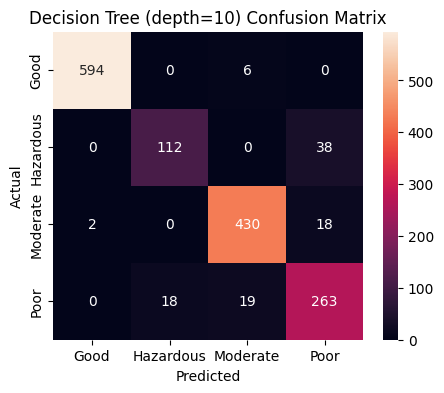


=== Random Forest (n=50) ===
Accuracy: 0.9533
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       600
   Hazardous       0.90      0.80      0.85       150
    Moderate       0.96      0.98      0.97       450
        Poor       0.87      0.90      0.89       300

    accuracy                           0.95      1500
   macro avg       0.93      0.92      0.93      1500
weighted avg       0.95      0.95      0.95      1500



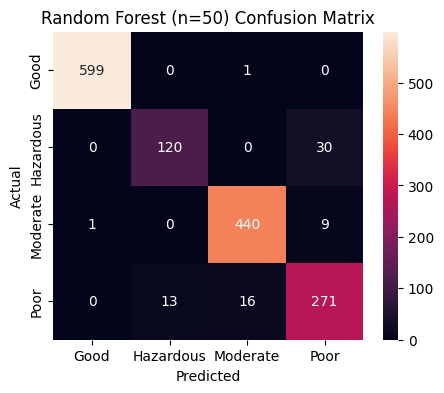


=== SVM (C=10) ===
Accuracy: 0.9487
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       600
   Hazardous       0.89      0.83      0.86       150
    Moderate       0.96      0.96      0.96       450
        Poor       0.86      0.89      0.88       300

    accuracy                           0.95      1500
   macro avg       0.93      0.92      0.92      1500
weighted avg       0.95      0.95      0.95      1500



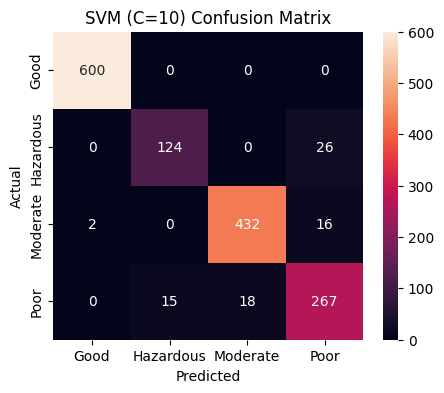


=== KNN (k=3) ===
Accuracy: 0.9400
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99       600
   Hazardous       0.91      0.79      0.85       150
    Moderate       0.93      0.97      0.95       450
        Poor       0.88      0.85      0.86       300

    accuracy                           0.94      1500
   macro avg       0.92      0.90      0.91      1500
weighted avg       0.94      0.94      0.94      1500



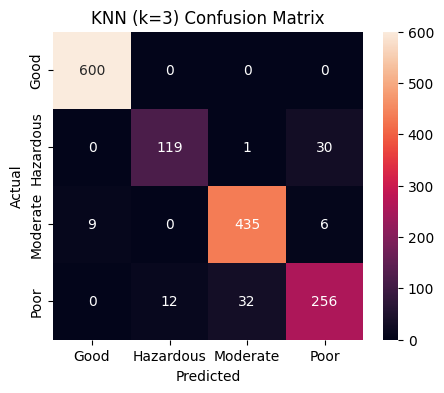


=== NeuralNet (50,) ===
Accuracy: 0.9487
              precision    recall  f1-score   support

        Good       0.99      1.00      1.00       600
   Hazardous       0.88      0.81      0.85       150
    Moderate       0.96      0.97      0.96       450
        Poor       0.88      0.89      0.88       300

    accuracy                           0.95      1500
   macro avg       0.93      0.92      0.92      1500
weighted avg       0.95      0.95      0.95      1500



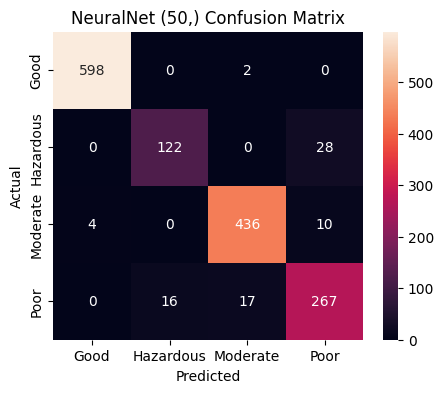


Model Comparison:
                      Model  Accuracy
0  Decision Tree (depth=10)  0.932667
1      Random Forest (n=50)  0.953333
2                SVM (C=10)  0.948667
3                 KNN (k=3)  0.940000
4           NeuralNet (50,)  0.948667


In [17]:
# Evaluate ALL final chosen models (with confusion matrix)

final_models = {
    f"Decision Tree (depth={best_dt_depth})": best_dt_model,
    f"Random Forest (n={best_rf_n})": best_rf_model,
    f"SVM (C={best_svm_C})": best_svm_model,
    f"KNN (k={best_knn_k})": best_knn_model,
    f"NeuralNet {best_nn_size}": best_nn_model
}

for name, model in final_models.items():
    print(f"\n=== {name} ===") 
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    results.append({"Model": name, "Accuracy": acc})


# Summary Table
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


## model comparison 

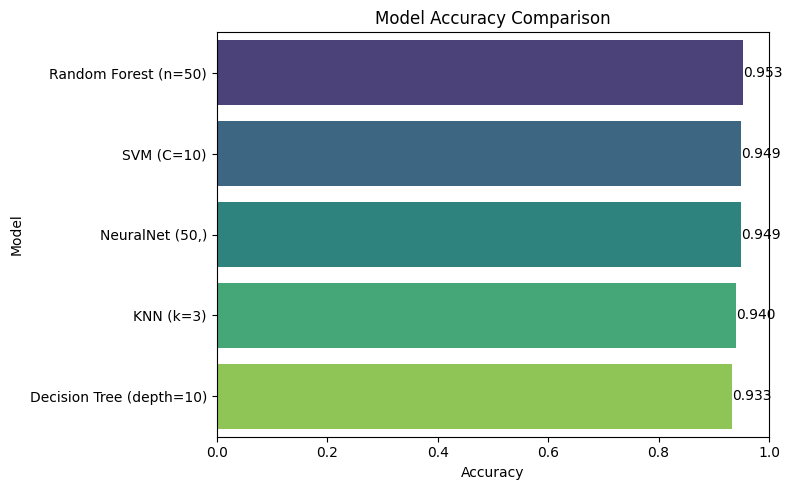

In [18]:
# Sort models by accuracy
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')

# Add labels and title
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Annotate bars with accuracy values
for i, (accuracy, model) in enumerate(zip(results_df['Accuracy'], results_df['Model'])):
    plt.text(accuracy, i, f"{accuracy:.3f}", va='center')

plt.tight_layout()
plt.show()


In [19]:
final_models

{'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
 'Random Forest (n=50)': RandomForestClassifier(n_estimators=50, random_state=42),
 'SVM (C=10)': SVC(C=10, probability=True, random_state=42),
 'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
 'NeuralNet (50,)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)}

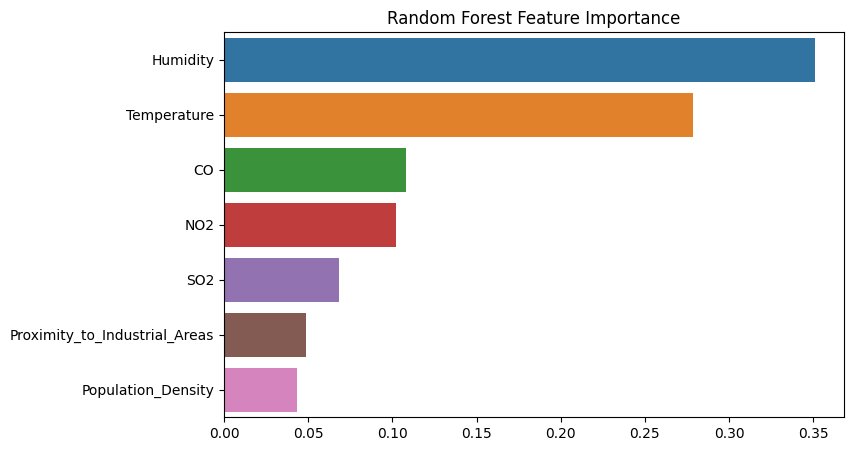

In [21]:
rf = final_models["Random Forest (n=50)"]
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=numeric_cols).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title("Random Forest Feature Importance")
plt.show()


In [ ]:
from sklearn import tree

tree_0 = rf.estimators_[0]

# Print human-readable text version - Showing only two levels for eye visualization
tree_rules = export_text(tree_0, feature_names=list(X_train.columns))
plt.figure(figsize=(20, 10))
plt.figure(figsize=(20, 10))
tree.plot_tree(
    model.estimators_[0],
    feature_names=X_train.columns,
    class_names=[str(c) for c in le.classes_],
    filled=True,
    rounded=True,
    max_depth=3
)

plt.savefig("random_forest_tree.png", dpi=300, bbox_inches='tight')  # 300 DPI for high quality

plt.show()



In [ ]:
daily_updates = pd.read_csv('latam_air_quality_real.csv')  # adjust filename

In [ ]:
print(daily_updates.isnull().sum())


In [ ]:
df

In [ ]:
daily_updates = daily_updates.dropna()


In [ ]:
print(daily_updates.isnull().sum())


In [ ]:
daily_updates.reset_index(drop=True, inplace=True)

In [ ]:
daily_updates

In [ ]:
# Keep only the selected features
X_new = daily_updates[selected_features]

# Apply the same scaler used during training
X_new_scaled = scaler.transform(X_new)

# Encode target if available (for evaluation)
y_new = None
if 'Air_Quality_Label' in daily_updates.columns:
    y_new = le.transform(daily_updates['Air_Quality_Label'])


In [ ]:
y_pred_new = models['SVM'].predict(X_new_scaled)


In [ ]:
y_pred_labels = le.inverse_transform(y_pred_new)
print(y_pred_labels)


In [ ]:
# -----------------------------
# Step 1: Prepare features
# -----------------------------
# Ensure all selected features exist
missing_cols = [c for c in selected_features if c not in daily_updates.columns]
if missing_cols:
    raise ValueError(f"Missing columns in new data: {missing_cols}")

X_new = daily_updates[selected_features].copy()

# Handle missing values (if any)
X_new.fillna(X_new.mean(), inplace=True)

# Apply the same scaler used during training
X_new_scaled = scaler.transform(X_new)

# -----------------------------
# Step 2: Prepare target (if exists)
# -----------------------------
y_new = None
if 'Air_Quality_Label' in daily_updates.columns:
    # Ensure all labels exist in the original LabelEncoder
    new_labels = daily_updates['Air_Quality_Label'].unique()
    unseen_labels = set(new_labels) - set(le.classes_)
    if unseen_labels:
        raise ValueError(f"New data contains unseen labels: {unseen_labels}")
    
    y_new = le.transform(daily_updates['Air_Quality_Label'])

# -----------------------------
# Step 3: Predict
# -----------------------------
y_pred_new = models['Random Forest'].predict(X_new_scaled)
y_pred_labels = le.inverse_transform(y_pred_new)
print("Predicted labels for new data:")
print(y_pred_labels)

# -----------------------------
# Step 4: Evaluate (if target exists)
# -----------------------------
if y_new is not None:
    acc = accuracy_score(y_new, y_pred_new)
    print(f"\nAccuracy on new data: {acc:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_new, y_pred_new, target_names=le.classes_))
    
    cm = confusion_matrix(y_new, y_pred_new)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix - New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
y_new

In [ ]:
architecture = """
High-Level System Architecture for Air Quality ML Notebook

1) Data Sources
    - Historical dataset (Kaggle): updated_pollution_dataset.csv  (cells: 2,3)
    - Daily updates feed (CSV): latam_air_quality_real.csv        (cells: 19,22-25)

2) Ingestion & Storage
    - Kaggle API downloads and unzips into local data directory (cell 2)
    - Daily CSVs loaded into a DataFrame (cell 19)
    - Raw files stored on disk under out_dir (./data)

3) Preprocessing
    - Cleaning: drop/inspect nulls, reset index (cells: 4,5,21,22,23,24)
    - Renaming & simple transforms (cell 6)
    - Label encoding of target (cell 8)
    - Scaling numeric features with StandardScaler (cells: 10,16,26,29)

4) Exploratory Data Analysis & Visualization
    - Class counts, heatmaps, correlation plots (cells: 7,11)
    - Feature importance and decision tree visualization (cells: 14,15,18)
    - Model comparison plots (cells: 13,17)

5) Feature Selection
    - Correlation-based selection (cell: 16) -> selected_features

6) Modeling & Training
    - Train/test split (cells: 12,16)
    - Models trained: Decision Tree, Random Forest, SVM, KNN, MLP (cell 16)
    - Hyperparameter sweep for RandomForest n_estimators (cell 13)

7) Evaluation
    - Accuracy, classification report, confusion matrices per model (cells: 13,16)
    - Summary comparison table (cells: 16,17)

8) Serving / Prediction on New Data
    - Prepare new daily records with same selected_features and scaler (cells: 26,29)
    - Predict using chosen model (cells: 27,29)
    - Inverse-transform labels for human-readable output (cell: 28)

9) Monitoring & Retraining (recommended)
    - Track accuracy on incoming labeled data (cell: 29)
    - Retrain when performance degrades or new classes appear

10) Dependencies & Artifacts
     - Libraries: pandas, scikit-learn, seaborn, matplotlib, kaggle
     - Artifacts to persist: fitted scaler, label encoder, trained model(s), selected_features

Simple ASCII flow:
  [Kaggle / Daily CSV] --> [Ingestion] --> [Preprocessing] --> [Feature Selection] --> [Train/Test Split] --> [Model Training & Tuning] --> [Evaluation & Visualizations]
                                                                                                                                                                      \
                                                                                                                                                                        -> [Save Model + Scaler + Encoder]
                                                                                                                                                                        -> [New Daily Data] --> [Preprocess (same pipeline)] --> [Predict] --> [Report / Monitor]

Notebook cell mapping (key):
 - Ingestion: 2,3
 - Cleaning & EDA: 4-11
 - Scaling & Split: 10-12
 - RF Tuning & plotting: 13-15
 - Feature selection & multi-model eval: 16-18
 - New-data ingestion & prediction: 19-29

Recommended next steps:
 - Persist model/scaler/encoder with joblib
 - Add a small wrapper (Flask/FastAPI) for serving predictions
 - Automate ingestion + monitoring + scheduled retraining
"""
print(architecture)